 ## L* Methodology

Producing a clean event log is the foundation for the next steps:  
**Step 1** (Obtain an Event Log)  
**Step 2** (Discovery via Inductive Miner → Petri net/BPMN)  
**Step 3** (Conformance via Token Replay)  
**Step 4** (Extending with case, organizational, and time perspectives)  

## Phase 1 - Preprocessing

 ### Step 1: Obtain an Event Log

In [ ]:
#!pip install pm4py

import pandas as pd
import numpy as np
from datetime import timedelta

import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

# Corrected imports for pm4py 2.x+
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.bpmn import visualizer as bpmn_visualizer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.util import xes_constants as xes
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load your data ---
file_name1 = "Procure-to-Pay.csv"
file_name2 = "Procure-to-Pay 2.csv"
file_name3 = "Procure-to-Pay 3.csv"

df1 = pd.read_csv(file_name1)
df2 = pd.read_csv(file_name2)
df3 = pd.read_csv(file_name3)
df = pd.concat([df1, df2, df3], ignore_index=False)

if not df.empty:
    # Standardize column names
    df = df.rename(columns={
        "Case ID": "case:concept:name",
        "Activity": "concept:name",
        "Complete Timestamp": "time:timestamp",
        "Resource": "org:resource",
        "Role": "org:role",
        "Invoice amount": "invoice_amount",
        "Discount": "discount",
        "Country": "country",
        "Start Timestamp": "time:start"
    })

    # Parse timestamps
    df["time:timestamp"] = pd.to_datetime(df["time:timestamp"], errors="coerce")
    if "time:start" in df.columns:
        df["time:start"] = pd.to_datetime(df["time:start"], errors="coerce")

    # Keep essential cols
    essential = ["case:concept:name", "concept:name", "time:timestamp"]
    missing = [c for c in essential if c not in df.columns]

    if not missing:
        # Sort events
        df = df.sort_values(["case:concept:name", "time:timestamp"]).reset_index(drop=True)

        # Sanity: drop events missing timestamps, activities, or case ids
        df = df.dropna(subset=["case:concept:name", "concept:name", "time:timestamp"]).copy()
        print("Data pre-processing complete. Head:")
        print(df.head())
    else:
        print(f"Missing required columns: {missing}")
        print("Available columns:", df.columns.tolist())


Data pre-processing complete. Head:
   case:concept:name          time:start      time:timestamp  \
0                 10 2020-01-02 02:52:00 2020-01-02 03:43:00   
1                 10 2020-01-02 10:25:00 2020-01-02 10:32:00   
2                 10 2020-01-02 15:32:00 2020-01-02 15:59:00   
3                 10 2020-01-03 12:50:00 2020-01-03 13:07:00   
4                 10 2020-01-03 13:31:00 2020-01-03 14:28:00   

                             concept:name         org:resource  \
0             Create Purchase Requisition      Esmana Liubiata   
1  Create Request for Quotation Requester  Immanuel Karagianni   
2           Analyze Request for Quotation  Francois de Perrier   
3  Send Request for Quotation to Supplier       Karel de Groot   
4         Create Quotation comparison Map       Karel de Groot   

           org:role  invoice_amount   discount country  
0         Requester      1128454.32  209219.21     SGP  
1         Requester      1128454.32  209219.21     SGP  
2  Purchasi

/tmp/ipython-input-488805687.py:45: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["time:timestamp"] = pd.to_datetime(df["time:timestamp"], errors="coerce")
/tmp/ipython-input-488805687.py:47: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["time:start"] = pd.to_datetime(df["time:start"], errors="coerce")


- **Loads** three CSV fragments and **concatenates** them into one event table.
- **Standardizes column names** to the widely used PM4Py/XES‑style schema:

  - case:concept:name (Case ID)  
  - concept:name (Activity)  
  - time:timestamp (Event time; we’ll use Complete Timestamp)  
  - org:resource / org:role (Organizational perspective)
  - invoice_amount, discount, country (Case/data perspective)  
  - time:start (optional start time to compute service times).  


- **Parses timestamps, sorts events** by case/time, and **drops invalid rows**.
These are the same preprocessing actions emphasized in the paper before discovery and conformance (they extracted from multiple sources, normalized attributes, and produced a clean event log).

### Step 2 - Create / Discover a Process Model (Event Log Creation)

In [ ]:
# Convert to pm4py event log
parameters = {xes.DEFAULT_TIMESTAMP_KEY: "time:timestamp"}
event_log = log_converter.apply(df, parameters=parameters, variant=log_converter.Variants.TO_EVENT_LOG)
len(event_log)


380

transforms the table into a **true event log** object, following the XES semantics used in process mining tools such as PM4Py, ProM, and Celonis.   This includes:

- Recognizing **cases** via case:concept:name
- Recognizing **activities** via concept:name
- Recognizing **timestamps** via time:timestamp
- Retaining **resource**, **role**, and **case** attributes

This matches how the paper took raw extracted data from Jira/GitHub and converted it into a structured log suitable for mining.

## Phase 2 — Process Mining

### Step 2.5 - Create / Discover the Process Model (Inductive Miner → Petri net)

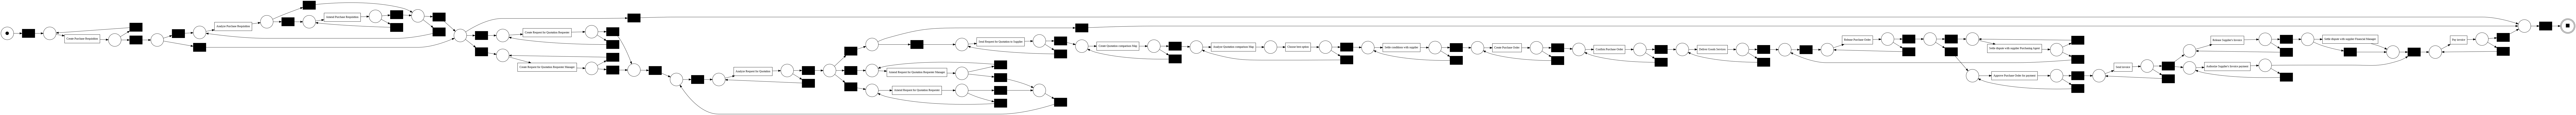

In [ ]:
# Inductive Miner - Corrected to return Petri net and markings
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log)

# Visualize Petri net
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

✔ The P2P process is strict, long, and stable
There are many mandatory steps executed in a fixed order.  
✔ The process has minimal deviations
The model is clean, with few loops and limited branching.  
✔ Variants exist, but they are small
Some branches handle different procurement paths (quotation/no quotation, approval variations).  
✔ The process is highly structured, which is why:

Inductive Miner produced a clean, long chain  
Conformance = 1.000  
No missing or remaining tokens  
All 380 cases followed the model perfectly  

### Step 3 - Conformance Checking with Token‑Based Replay (TBR)

In [ ]:
replay_result = token_replay.apply(event_log, net, initial_marking, final_marking)

# Compute overall fitness
# pm4py returns per-trace results; summarize:
fitted = [r["trace_fitness"] for r in replay_result if "trace_fitness" in r]
overall_fitness = np.mean(fitted) if fitted else np.nan
print(f"Overall token-replay fitness: {overall_fitness:.3f}")

# Activity-level issues (simple diagnostic)
# Count missing or remaining tokens (rough indicator)
missing = sum(r.get("missing_tokens", 0) for r in replay_result)
remaining = sum(r.get("remaining_tokens", 0) for r in replay_result)
print(f"Missing tokens: {missing}, Remaining tokens: {remaining}")

replaying log with TBR, completed traces ::   0%|          | 0/88 [00:00<?, ?it/s]

Overall token-replay fitness: 1.000
Missing tokens: 0, Remaining tokens: 0


- **completed traces** :: 100% → Every trace in the log could be replayed on the model (none failed).
- **Overall token-replay fitness**: 1.000 → Perfect fitness: the model can reproduce every observed sequence without deviations.
- **Missing tokens**: 0, Remaining tokens: 0 → No tokens had to be artificially added (no “unexpected” events), and none were stranded at the end (no “unfinished” behavior).  
 This indicates clean start and end conformance for all cases.

## Phase 3 — Mining Perspectives

### Step 4 - Case/Data Perspective: Variant (Trace) Analysis

In the **L * life‑cycle model**, once the model has been discovered and validated via **conformance**, we extend the analysis with additional perspectives.  
 The **case perspective** focuses on variants,the distinct sequences of activities (traces) that cases follow.

In [ ]:
from pm4py.algo.filtering.log.variants import variants_filter as variants_get
from pm4py.statistics.traces.generic.log import case_statistics

# Variants (traces)
variants = variants_get.get_variants(event_log)
print(f"Total variants: {len(variants)}")

# Top variants by frequency
variant_stats = case_statistics.get_variant_statistics(event_log)
variant_stats = sorted(variant_stats, key=lambda x: x["count"], reverse=True)[:10]
variant_stats

Total variants: 88


[{'variant': ('Create Purchase Requisition',
   'Analyze Purchase Requisition',
   'Create Request for Quotation Requester Manager',
   'Analyze Request for Quotation',
   'Send Request for Quotation to Supplier',
   'Create Quotation comparison Map',
   'Analyze Quotation comparison Map',
   'Choose best option',
   'Settle conditions with supplier',
   'Create Purchase Order',
   'Confirm Purchase Order',
   'Deliver Goods Services',
   'Release Purchase Order',
   'Approve Purchase Order for payment',
   'Send invoice',
   "Release Supplier's Invoice",
   "Authorize Supplier's Invoice payment",
   'Pay invoice'),
  'count': 43},
 {'variant': ('Create Purchase Requisition',
   'Create Request for Quotation Requester',
   'Analyze Request for Quotation',
   'Send Request for Quotation to Supplier',
   'Create Quotation comparison Map',
   'Analyze Quotation comparison Map',
   'Choose best option',
   'Settle conditions with supplier',
   'Create Purchase Order',
   'Confirm Purchase 

1. **Two dominant, end‑to‑end “straight‑through” variants**
  - E.g., the 1st and 2nd variants run all the way to Pay invoice, differing early in the RFQ stage (one includes Analyze Purchase Requisition and Create Request for Quotation Requester Manager; the other takes Create Request for Quotation Requester without the “Manager” step).  

**Interpretation**: You likely have two policy routes—with and without managerial involvement—both culminating in payment. This is typical in P2P where approval thresholds or business rules drive different paths.



2. **Short “early‑stop” variants** (e.g., only Create Purchase Requisition → Analyze Purchase Requisition)

  - These sequences terminate far earlier than the payment stage.  
**Interpretation hypotheses**:
    - Legitimate terminations (rejected/cancelled requisitions; below‑threshold purchases diverted off‑system), or
    - Data‑scope limits (downstream events logged in another system or not captured in these CSV extracts).  

Both issues—legitimate divergence vs. data incompleteness—are called out as practical challenges in the paper’s preprocessing step and SME context.



3. **Evidence of rework loops / repeated steps**
    - One variant shows repeated occurrences of the same activities (e.g., Create Request for Quotation Requester, Send Request for Quotation to Supplier, Create Quotation comparison Map, approvals, and even Pay invoice appearing twice).  

**Interpretation**: This indicates rework or logging duplications (e.g., multiple RFQ rounds, repeated approvals, or duplicate event recording).  
The paper emphasizes that such behavior becomes visible in the discovered model and in variants, and is crucial for identifying improvement opportunities.



4. **Exceptional paths with dispute handling**
    - Some variants include steps like Settle dispute with supplier Financial Manager.  

**Interpretation**: This is a low‑frequency exception route triggered by discrepancies (goods, invoice, or contractual).   
The L* methodology recommends bringing such exceptions into the integrated view to understand their time/role impact.



5. **Amendments in the RFQ stage**
    - Variants with Amend Request for Quotation Requester show iterative correction before proceeding.  

**Interpretation**: Normal in RFQ processes; worth quantifying because amendments tend to extend lead times and involve additional roles—key insights for the integrated model.

### Step 4.1 (Case + Time Perspectives)

we extend the model by projecting case attributes and time onto the discovered control‑flow to obtain a more holistic view of the process.  
Here, we compute per‑case throughput time and segment it by monetary value bands

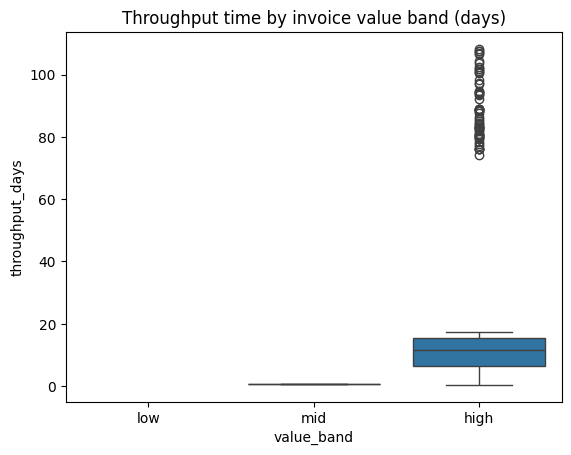

In [ ]:
df_cases = (df.groupby("case:concept:name", as_index=False)
              .agg({
                   "invoice_amount":"max",
                   "discount":"max",
                   "country":"first",
                   "time:timestamp":["min","max"]
               }))
df_cases.columns = ["case:concept:name","invoice_amount","discount","country","start","end"]
df_cases["throughput_days"] = (df_cases["end"] - df_cases["start"]).dt.total_seconds()/86400

# Example segmentation
bins = [-np.inf, 1000, 10000, np.inf]
labels = ["low","mid","high"]
df_cases["value_band"] = pd.cut(df_cases["invoice_amount"].fillna(0), bins=bins, labels=labels)

sns.boxplot(data=df_cases, x="value_band", y="throughput_days")
plt.title("Throughput time by invoice value band (days)")
plt.show()

Higher invoice values tend to increase lead time and variance, with prominent outliers that may merit root‑cause analysis

### Step 4.2 (Organizational Perspective): Who does what?

 Here we implement the organizational perspective in the L* methodology by quantifying which roles execute which activities and visualizing the distribution as a Role × Activity heatmap.

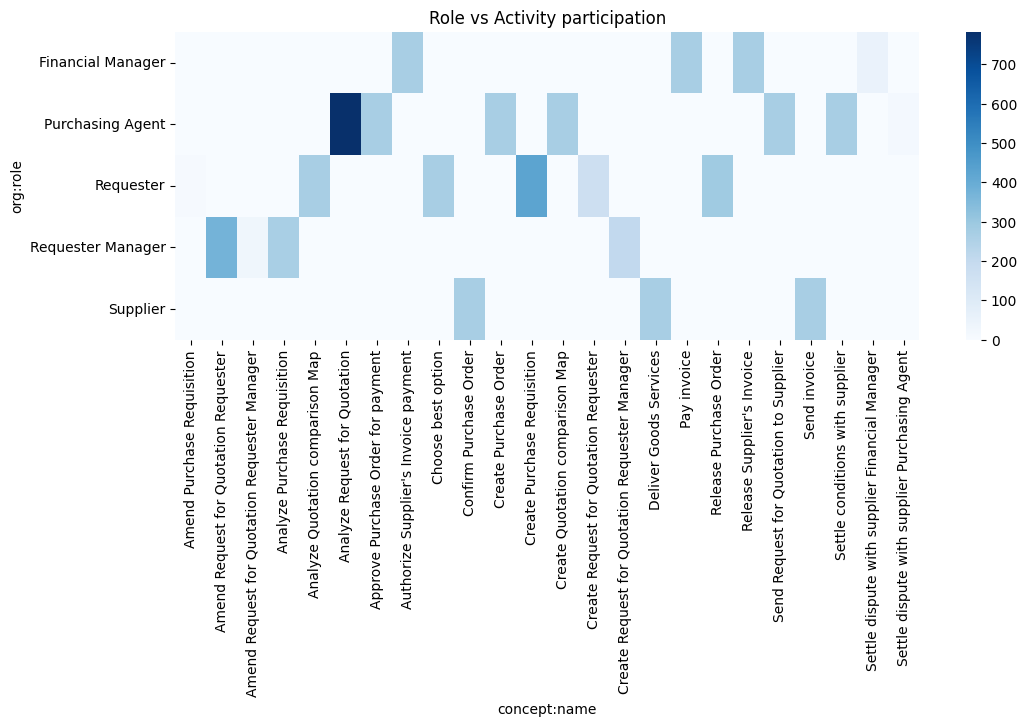

In [ ]:
# Frequency by role and activity
role_act = (df.groupby(["org:role","concept:name"])
              .size()
              .reset_index(name="count")
              .sort_values("count", ascending=False))
role_act.head(10)

# Simple heatmap of who does what
pivot = role_act.pivot(index="org:role", columns="concept:name", values="count").fillna(0)
plt.figure(figsize=(12, 4))
sns.heatmap(pivot, annot=False, cmap="Blues")
plt.title("Role vs Activity participation")
plt.show()

- **Strong role specialization is visible:**

Purchasing Agent performs the majority of sourcing, RFQ, quotation analysis, and PO‑related steps — confirming it as the operational core of the P2P cycle.
Requester / Requester Manager dominates early‑stage requisition and RFQ creation activities.
Financial Manager mainly appears in the late approval and payment authorization stages.
Supplier only appears in delivery and invoicing activities — appropriate for external actors.



- **Workload intensity is uneven:**

The heatmap shows the Purchasing Agent carrying a significantly heavier activity load compared to all other roles.
This concentration suggests a potential bottleneck, especially in mid‑process steps such as quotation comparison and PO processing.



- **Exception paths are traceable to specific roles:**

Activities like “Settle dispute with supplier Financial Manager” occur rarely but exclusively involve Financial Manager, confirming proper escalation handling.



- **Healthy segregation of duties (SoD):**

Early activities (requesting) are clearly separated from financial approvals and payment authorization, indicating compliance‑aligned role distribution.



- **Organizational perspective confirms real operational behavior:**

Role activity patterns align logically with a typical Procure‑to‑Pay process, reflecting what the research paper describes: using this perspective to validate who is actually performing each part of the process and to identify imbalances or risks before building the integrated model.

### Step 4.3 (Time Perspective): Inter‑event waiting times per activity

In [ ]:
# Inter-event waiting times per activity (from ordered events in a case)
df["next_time"] = df.groupby("case:concept:name")["time:timestamp"].shift(-1)
df["delta_s"] = (df["next_time"] - df["time:timestamp"]).dt.total_seconds()

time_stats = (df.groupby("concept:name")["delta_s"]
                .agg(["count","mean","median","min","max"])
                .assign(mean_h=lambda x: x["mean"]/3600,
                        max_d=lambda x: x["max"]/86400))
time_stats

,count,mean,median,min,max,mean_h,max_d
concept:name,,,,,,,
Amend Purchase Requisition,10,43650.000000,39960.0,0.0,88500.0,12.125000,1.024306
Amend Request for Quotation Requester,374,651166.684492,172260.0,0.0,6449400.0,180.879635,74.645833
Amend Request for Quotation Requester Manager,33,979034.545455,440880.0,0.0,5128260.0,271.954040,59.354861
Analyze Purchase Requisition,222,2169.729730,420.0,0.0,44820.0,0.602703,0.518750
Analyze Quotation comparison Map,270,0.000000,0.0,0.0,0.0,0.000000,0.000000
Analyze Request for Quotation,690,26638.695652,3900.0,0.0,231360.0,7.399638,2.677778
Approve Purchase Order for payment,270,165571.333333,95850.0,0.0,974400.0,45.992037,11.277778
Authorize Supplier's Invoice payment,270,2415.555556,2340.0,0.0,5460.0,0.670988,0.063194
Choose best option,270,69006.444444,57510.0,0.0,400680.0,19.168457,4.637500


A) **“Where time accumulates” — long typical waits (by median)**

- Confirm Purchase Order → ~2.36 days median wait (max ≈ 36.16 days): downstream confirmations are a major time sink.
- Create Request for Quotation (Requester/Manager) → ~1.51–1.63 days median (max ≈ 75–89 days): the RFQ initiation/approval chain introduces substantial waiting, with very long outliers.
- Approve Purchase Order for payment → ~1.11 days median (max ≈ 11.28 days): finance approvals add >1 day typically, sometimes much more.
- Create / Release / Send steps in the mid‑flow (e.g., Create PO, Release PO, Send RFQ to Supplier, Choose best option) show 6–18 hours median waits — not trivial and cumulatively material.

B) **“Volatility and risk” — extreme outliers (by max)**

- Create RFQ (Requester) up to ~88.6 days, Create RFQ (Manager) up to ~75.3 days, Amend RFQ (Requester) up to ~74.6 days, Confirm PO up to ~36.2 days, Create PO up to ~20.6 days.
These long‑tail waits align with what the paper emphasizes: certain stages (esp. approvals or external coordination) can dominate case‑level throughput and should be prioritized in improvement actions.

C) **“Fast/instantaneous” segments (often batched/terminal)**

- Authorize Supplier’s Invoice payment: ~39 minutes median (tight cluster).
- Release Supplier’s Invoice: median 0 s, mean ~11 min (likely same‑timestamp logging or immediate follow‑up).
- Settle dispute with supplier (Financial Manager): near‑zero waits (very short micro‑steps).
Such near‑zero medians are typical for system‑triggered or batched actions logged together; the paper notes timestamp granularity/automation can produce these patterns.

### Step 4.4 (Control‑Flow Enhancement): Frequency‑Annotated Petri Net

this is part of Step 4 (extend the model), where you project log information back onto the model to enrich the control‑flow with operational evidence prior to returning the integrated model in Step 5.

replaying log with TBR, completed traces ::   0%|          | 0/88 [00:00<?, ?it/s]

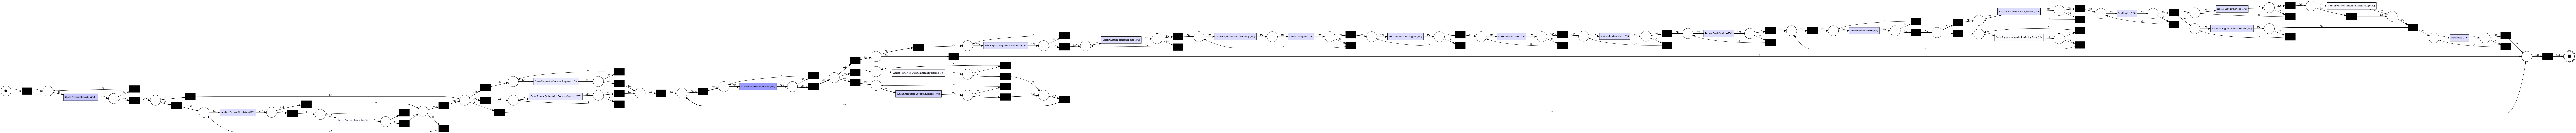

In [ ]:
# Performance annotation on petri net by frequency
# Note: pm4py.algo.enhancement is deprecated in favor of visualizer variants

# Frequency visualization - we pass the log to the visualizer to calculate frequencies
# Use 'png' instead of 'svg' to ensure compatibility with the display environment
parameters = {"format": "png"}
gviz_freq = pn_visualizer.apply(
    net,
    initial_marking,
    final_marking,
    log=event_log,
    variant=pn_visualizer.Variants.FREQUENCY,
    parameters=parameters
)
pn_visualizer.view(gviz_freq)

# To visualize performance (throughput times), use the PERFORMANCE variant:
# gviz_perf = pn_visualizer.apply(
#     net,
#     initial_marking,
#     final_marking,
#     log=event_log,
#     variant=pn_visualizer.Variants.PERFORMANCE,
#     parameters=parameters
# )
# pn_visualizer.view(gviz_perf)

These observations exemplify how the paper leverages frequency and perspective overlays to identify dominant traces, rare paths, and rework, informing where to focus improvement and monitoring.

In [ ]:
import pm4py

# Read the selected XES file
log_path = "/content/Logs before Prom Filtering.xes"
log = pm4py.read_xes(log_path)

# Display summary statistics
traces_count = len(log)
events_count = sum(len(trace) for trace in log)

print(f"Event Log: {log_path}")
print(f"Total Traces: {traces_count}")
print(f"Total Events: {events_count}")

/usr/local/lib/python3.12/dist-packages/pm4py/utils.py:1000: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/1231 [00:00<?, ?it/s]

Event Log: /content/Logs before Prom Filtering.xes
Total Traces: 10359
Total Events: 130


In [ ]:
log

,Type,org:resource,concept:name,Refer from,Gender,Service fees,lifecycle:transition,FinishDate,ActivityNo,time:timestamp,Age,case:concept:name
0,open heart,Receptionist 3,Admission to Hospital,Doctor,Female,0,complete,0021-03-30 09:30:00+00:00,A21628,0021-03-30 09:00:00+00:00,58,10019171
1,open heart,General Practitioner2,1st Consultant Checkup,Doctor,Female,0,complete,0021-03-30 10:00:00+00:00,A21638,0021-03-30 09:30:00+00:00,58,10019171
2,open heart,Laboratory specialist 1,Laboratory Tests,Doctor,Female,0,complete,0021-03-30 13:00:00+00:00,A21648,0021-03-30 10:00:00+00:00,58,10019171
3,open heart,Radiology specialist 2,Radiology Tests,Doctor,Female,0,complete,0021-03-31 01:20:00+00:00,A21658,0021-03-31 01:00:00+00:00,58,10019171
4,open heart,Catheter and stent surgery team1,Cardiac Stent,Doctor,Female,0,complete,0021-04-04 10:40:00+00:00,A21668,0021-04-04 10:00:00+00:00,58,10019171
...,...,...,...,...,...,...,...,...,...,...,...,...
10354,inspect cath,Laboratory specialist 1,Laboratory Tests,Emergency,Male,0,complete,0021-06-24 14:29:00+00:00,A43448,0021-06-24 11:29:00+00:00,80,99719131
10355,inspect cath,Radiology specialist 1,Radiology Tests,Emergency,Male,0,complete,0021-06-24 14:29:00+00:00,A43458,0021-06-24 11:29:00+00:00,80,99719131
10356,inspect cath,Catheter and stent surgery team2,Diagnostic Catheterization,Emergency,Male,0,complete,0021-06-26 12:59:00+00:00,A43468,0021-06-26 12:00:00+00:00,80,99719131
10357,inspect cath,ward nurse 1,Recuperation Ward,Emergency,Male,0,complete,0021-06-26 13:19:00+00:00,A43478,0021-06-26 12:59:00+00:00,80,99719131
